In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
import torch.optim as optim

In [ ]:
# IMU-Based Energy Expenditure Estimation for Various Walking Conditions Using a Hybrid CNN–LSTM Model
# conv1d(64, 3)
# maxpooling1d(64, 3)
# 2 LSTM 64 hidden units
# flatten layer
# fully connected layer
# output

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class DataProcessor:
    def __init__(self, person, weight, attempt):
        self.person = person
        self.weight = weight
        self.attempt = attempt

    def load_imu_data(self, person, weight, attempt):
        imu_path = f'/content/drive/MyDrive/Colab_Notebooks/Master_Thesis/Neural_Network/Dataset/P{person}/W{weight}/A{attempt}/imu/data_neural.csv'
        imu_data = pd.read_csv(imu_path)  # Load CSV data using pandas

        imu_chunks = []
        num_timesteps = imu_data.shape[0]
        num_chunks = num_timesteps // 100
        remainder = num_timesteps % 100

        for i in range(num_chunks):
            chunk = imu_data.iloc[i * 100: (i + 1) * 100]
            imu_chunks.append(torch.tensor(chunk.values))

        if remainder > 20:
            last_chunk = imu_data.iloc[-100:]
            imu_chunks.append(torch.tensor(last_chunk.values))

        return imu_chunks

    def load_emg_data(self, person, weight, attempt):
        emg_path = f'/content/drive/MyDrive/Colab_Notebooks/Master_Thesis/Neural_Network/Dataset/P{person}/W{weight}/A{attempt}/emg/emg_label.csv'
        emg_data = pd.read_csv(emg_path)  # Load CSV data using pandas
        emg_tensor = torch.tensor(emg_data.iloc[:, 1])  # Convert DataFrame to tensor
        return emg_tensor

    def process_data(self):
        all_data = []

        for p in range(1, self.person + 1):
            for w in range(1, self.weight + 1):
                for a in range(1, self.attempt + 1):
                    emg_data = self.load_emg_data(p, w, a)
                    imu_data = self.load_imu_data(p, w, a)
                    for chunk in range(len(imu_data)):
                        imu_chunk = imu_data[chunk]
                        all_data.append((imu_chunk, emg_data))

            print(f'Person {p}/{self.person} done')

        return all_data

# Example usage:
person = 10
weight = 5
attempt = 6

processor = DataProcessor(person, weight, attempt)
all_data = processor.process_data()
print(len(all_data))
for i in range(len(all_data)):
    data, label = all_data[i]
    print(data.shape, label)
print(data)
print(label)
print(all_data[-1])

Person 1/10 done
Person 2/10 done
Person 3/10 done
Person 4/10 done
Person 5/10 done
Person 6/10 done
Person 7/10 done
Person 8/10 done
Person 9/10 done
Person 10/10 done
942
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([1])
torch.Size([100, 13]) tensor([1])
torch.Size([100, 13]) tensor([1])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Size([100, 13]) tensor([2])
torch.Siz

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_data, out_channels=64, kernel_conv=1, kernel_pool=1, hidden_lstm=64, layers_lstm=1, num_classes=5, time_steps=100):
        super(CNN_LSTM, self).__init__()
        self.batch_size = batch_size

        # Linear layer
        self.linear1 = nn.Linear(time_steps*num_data, num_data)

        # 1D Convolutional Layer
        self.conv1 = nn.Conv1d(in_channels=num_data, out_channels=64, kernel_size=kernel_conv).double()

        # Max Pooling Layer
        self.pool1 = nn.MaxPool1d(kernel_size=kernel_pool).double()

        # LSTM layers
        self.lstm = nn.LSTM(out_channels, hidden_lstm, layers_lstm, batch_first=True).double()

        # Fully connected layer for regression
        self.fc1 = nn.Linear(out_channels, num_classes).double() # Output dimension is 1 for regression

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 1e-1)
                nn.init.zeros_(m.bias)

    def forward(self, x): # shape (batch_size, time_steps, num_data) = (2, 100, 13)
        # print('1', np.shape(x))
        x = x.view(batch_size, -1) # shape (batch_size, 1*time_steps*num_data) = (2, 1300)
        # print('2', np.shape(x))
        x = self.linear1(x.float()) # shape (batch_size, 1*num_data) = (2, 13)
        # print('3', np.shape(x))
        x = x.view(batch_size, 1, 13) # shape (batch_size, 1, 1, num_data) = (2, 1, 13)
        # print('4', np.shape(x))
        x = F.relu(x) # shape (batch_size, num_sensors, 1, num_data) = (2, 1, 13)

        x = x.double()
        x = x.permute(0, 2, 1) # shape (batch_size, num_data, num_sensors) = (2, 13, 1)
        # print('5', np.shape(x))
        x = self.conv1(x) # shape (batch_size, out_channels, _) = (2, 64, 1)
        # print('6', np.shape(x))
        x = self.pool1(x) # shape (batch_size, out_channels, 1) = (2, 64, 1)
        # print('7', np.shape(x))
        x = F.relu(x) # shape (batch_size, out_channels, 1) = (2, 64, 1)

        x = x.squeeze(2) # shape (batch_size, out_channels) = (2, 64)
        # print('8', np.shape(x))
        x, _ = self.lstm(x) # shape (batch_size, out_channels) = (2, 64)

        x = self.fc1(x).float() # shape (batch_size, num_classes) = (2, 5)
        # print('9', np.shape(x))
        output = F.softmax(x, dim=1) # shape (batch_size, num_classes) = (2, 5)
        # print('10', np.shape(output))
        return output

In [ ]:
import sys
def train(model, train_loader, time_steps, criterion, optimizer, epochs=5, batch_size=1):
    model.train()
    losses = []
    total_batches = math.ceil(len(train_loader.dataset) / batch_size)
    for epoch in range(epochs):
        running_loss = 0.0
        print('-----------EPOCH %d-----------' % (epoch + 1))
        for i, data in enumerate(train_loader):
            if len(train_loader.dataset) % batch_size != 0 and i == total_batches - 1:
                break
            # print(i)
            inputs, labels = data
            optimizer.zero_grad()
            labels = labels.view(-1)
            inputs = inputs.float()
            outputs = model(inputs)
            # outputs = outputs.float()
            # labels = labels.long()
            # print(outputs)
            # outputs = torch.argmax(outputs, dim=1)
            # print('output:', outputs)
            # print('labels:', labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # losses.append(running_loss / total_batches)
            # running_loss += loss.item() * inputs.size(0)
            if (i + 1) % 20 == 0:
                print('[episode: %d] loss: %f' % (i + 1, running_loss / 2))
                losses.append(running_loss / 2)
                running_loss = 0.0

    print(outputs, labels)
    plt.plot(losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

def test(model, test_loader, batch_size=1):
    model.eval()
    total_error = 0
    total_batch = 0
    # total_error2 = 0
    total_batches = math.ceil(len(test_loader.dataset) / batch_size)
    # print(total_batches)
    # print(len(test_loader.dataset) % batch_size)
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            # print('i', i)
            # print('tot', total_batches)
            # print('%', len(test_loader.dataset) % batch_size)
            if len(test_loader.dataset) % batch_size != 0 and i == total_batches - 1:
                print('here')
                break
            inputs, labels = data
            inputs = inputs.float()
            labels = labels.long()
            labels = labels.view(-1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_error += loss.item()
            total_batch += 1
            # batch_error = torch.abs(outputs.flatten() - labels.flatten()) / labels.flatten()
            # batch_error2 = torch.abs(outputs.flatten() - labels.flatten())
            # total_error += batch_error.mean().item()
            # total_error2 += batch_error2.mean().item()
            if (i + 1) % 20 == 0:
                print(outputs, labels)
    # print('Average accuracy: %f %% ' % (100 - total_error / total_batches * 100))
    # print('Average error between prediction and label: %f' % (total_error2 / total_batches))
    average_loss = total_error / total_batch
    print('Average test loss: {:.4f}'.format(average_loss))

In [ ]:
data, label = all_data[0]
data_list = []
label_list = []
for i in range(len(all_data)):
  data, label = all_data[i]
  data_list.append(data)
  label_list.append(label)

num_rows = len(data_list)
indices = torch.randperm(num_rows).tolist()
shuffled_data = [data_list[i] for i in indices]
shuffled_labels = [label_list[i] for i in indices]

shuffled_dataset = (shuffled_data, shuffled_labels)

In [ ]:
print(shuffled_data[47], shuffled_labels[47])
print(np.shape(shuffled_data[47]))

tensor([[   2.3000,   60.6611,    4.4751,  ...,  347.8922,  225.5194,
         -638.4357],
        [   2.3100,   61.2873,    4.8536,  ...,  390.0192,  159.0597,
         -641.7383],
        [   2.3200,   61.8761,    5.0678,  ...,  419.8415,  102.9427,
         -631.5080],
        ...,
        [   3.2700,   93.7737,   21.7757,  ...,    0.6476,    5.3820,
          -57.7478],
        [   3.2800,   93.7907,   21.5518,  ...,    3.7258,    6.4994,
          -56.8238],
        [   3.2900,   94.0820,   21.5688,  ...,    9.1629,    9.0101,
          -55.1264]], dtype=torch.float64) tensor([3])
torch.Size([100, 13])


In [ ]:
# @title Testo del titolo predefinito
# data, labels = dataset[:, :]
# num_rows = data.shape[0]
# indices = torch.randperm(num_rows)
# shuffled_data = data[indices]
# shuffled_labels = labels[indices]
# shuffled_dataset = shuffled_data, shuffled_labels

# data, label = dataset[:]

batch_size = 2

train_set = [(shuffled_data[i], shuffled_labels[i]) for i in range(np.int64(len(all_data)/2))]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = [(shuffled_data[i], shuffled_labels[i]) for i in range(np.int64(len(all_data)/2), len(all_data))]
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# train_set = [(dataset[i]) for i in range(np.int64(len(dataset)/2))]
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# test_set = [(dataset[i]) for i in range(np.int64(len(dataset)/2), len(dataset))]
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)


-----------EPOCH 1-----------
[episode: 20] loss: 16.127323
[episode: 40] loss: 16.113498
[episode: 60] loss: 16.090457
[episode: 80] loss: 16.115999
[episode: 100] loss: 16.102585
[episode: 120] loss: 16.100410
[episode: 140] loss: 16.080276
[episode: 160] loss: 16.066629
[episode: 180] loss: 16.098530
[episode: 200] loss: 16.075558
[episode: 220] loss: 16.083069
-----------EPOCH 2-----------
[episode: 20] loss: 16.086945
[episode: 40] loss: 16.093089
[episode: 60] loss: 16.085530
[episode: 80] loss: 16.066200
[episode: 100] loss: 16.076301
[episode: 120] loss: 16.092007
[episode: 140] loss: 16.092189
[episode: 160] loss: 16.047240
[episode: 180] loss: 16.065498
[episode: 200] loss: 16.069759
[episode: 220] loss: 15.987030
-----------EPOCH 3-----------
[episode: 20] loss: 16.051503
[episode: 40] loss: 16.037075
[episode: 60] loss: 16.030660
[episode: 80] loss: 16.036643
[episode: 100] loss: 16.032609
[episode: 120] loss: 16.028692
[episode: 140] loss: 16.063416
[episode: 160] loss: 15

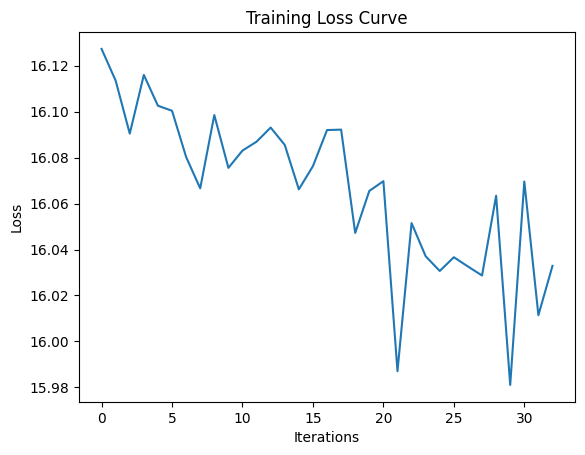

In [ ]:
num_data = np.shape(shuffled_data)[2]
time_steps = np.shape(shuffled_data)[1]
model = CNN_LSTM(num_data, layers_lstm=2)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, train_loader, time_steps, criterion, optimizer, epochs=3, batch_size=batch_size)

In [ ]:
test(model, test_loader, batch_size=batch_size)

tensor([[0.1624, 0.2314, 0.2041, 0.2080, 0.1941],
        [0.1613, 0.2366, 0.2018, 0.2181, 0.1823]]) tensor([2, 0])
tensor([[0.1592, 0.2217, 0.2071, 0.2083, 0.2037],
        [0.1625, 0.2197, 0.1979, 0.2154, 0.2044]]) tensor([4, 4])
tensor([[0.1610, 0.2384, 0.2034, 0.2012, 0.1960],
        [0.1539, 0.2257, 0.2124, 0.2065, 0.2016]]) tensor([3, 4])
tensor([[0.1701, 0.2283, 0.2094, 0.2070, 0.1853],
        [0.1555, 0.2240, 0.2069, 0.2192, 0.1944]]) tensor([2, 3])
tensor([[0.1526, 0.2166, 0.2075, 0.2176, 0.2057],
        [0.1616, 0.2215, 0.2121, 0.1963, 0.2085]]) tensor([4, 2])
tensor([[0.1521, 0.2052, 0.2065, 0.2336, 0.2026],
        [0.1537, 0.2087, 0.2029, 0.2366, 0.1982]]) tensor([2, 1])
tensor([[0.1629, 0.2203, 0.1988, 0.2150, 0.2031],
        [0.1640, 0.2282, 0.2067, 0.2180, 0.1832]]) tensor([3, 1])
tensor([[0.1618, 0.2222, 0.2044, 0.2102, 0.2013],
        [0.1588, 0.2270, 0.2068, 0.2158, 0.1915]]) tensor([4, 0])
tensor([[0.1618, 0.2151, 0.2013, 0.2160, 0.2058],
        [0.1604, 0.229